In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import awkward as ak
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sys
from keras.callbacks import EarlyStopping
from keras.models import load_model
import os
from tensorflow.keras import layers, models
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from sklearn.model_selection import train_test_split
import math
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

2024-03-05 10:56:03.831097: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-05 10:56:03.922075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getEnergyMatrix(file='Digi_SCECAL_gamma.root',target=0,entrystop=100):
    file = uproot.open(file)
    # Access the tree
    tree = file["ClusBar"]
    # Get the data for one event
    event_data = tree.arrays(["clusBar_Q1", "clusBar_Q2", "clusBar_module", "clusBar_crystal","clusBar_z","clusBar_x","clusBar_y","Photon_E_MC"])
    
    # Calculate E, Z, and phi
    E = (event_data["clusBar_Q1"] + event_data["clusBar_Q2"]) / 2
    x=event_data["clusBar_x"]
    y=event_data["clusBar_y"]
    Z=event_data["clusBar_z"]
    phi = np.arctan2(y, x)
    True_E=event_data["Photon_E_MC"]
    
    Z_center = np.sum(Z * E,axis=1) / np.sum(E,axis=1)
    phi_center = np.sum(phi * E,axis=1) / np.sum(E,axis=1)
    #E = E/np.sum(E,axis=1) ## normalize
    total_E=np.sum(E,axis=1)
    # Shift the Z and phi values so that the weighted center is at (0, 0)
    Z = Z - Z_center
    phi = phi - phi_center

    
    # Select only the points that are within 100 units of the maximum Z and phi values
    mask = (np.abs(Z) <= 200) & (np.abs(phi) <= 0.2)
    Z = Z[mask]
    phi = phi[mask]
    E = E[mask]

    ## Normalize energy for color mapping
    #E_norm = (E - np.min(E)) / (np.max(E) - np.min(E))
    
    # Create a scatter plot with the 'gray_r' colormap
    #plt.scatter(Z[1,:], phi[1,:], c=E_norm[1,:], cmap='hot_r',norm=matplotlib.colors.LogNorm(),marker='s')
    #plt.colorbar(label='Energy')
    #plt.xlabel('Z')
    #plt.ylabel('Phi')
    #plt.title('Event Visualization')
    #plt.show()
    
    Z_bins = np.linspace(-150, 150, 81)  # 80 bins from -200 to 200
    Z_binned = ak.Array([np.digitize(z, Z_bins) for z in Z])
    Z_binned_values = ak.Array([Z_bins[z_binned_event - 1] for z_binned_event in Z_binned])
    
    phi_bins = np.linspace(-0.2, 0.2, 81)
    phi_binned = ak.Array([np.digitize(p, phi_bins) for p in phi])
    phi_binned_values = ak.Array([phi_bins[p_binned_event - 1] for p_binned_event in phi_binned])
    
    # Create a scatter plot with the 'gray_r' colormap
    plt.scatter(Z_binned_values[1,:], phi_binned_values[1,:], c=E[1,:], cmap='hot_r',norm=matplotlib.colors.LogNorm(),marker='s')
    plt.colorbar(label='Energy')
    plt.xlabel('Z')
    plt.ylabel('Phi')
    plt.title('Event Visualization')
    plt.show()
    
    # Create a DataFrame to store the energy matrices
    df = pd.DataFrame(index=range(len(E)), columns=["energy_matrix"])
    # For each event, create a 2D histogram of Z and phi, weighted by E
    #energy_matrices = np.histogram2d(Z_binned_values, phi_binned_values, bins=(Z_bins, phi_bins), weights=E)[0]
    #df["energy_matrix"] = energy_matrices
    #df["E1"] = True_E[:, 0]
    #df["E2"] = True_E[:, 1]
    for i in range(len(E)):
        df.loc[i, "energy_matrix"] = np.histogram2d(Z_binned_values[i], phi_binned_values[i], bins=(Z_bins, phi_bins), weights=E[i])[0]
    #df["E1"] = True_E[:,0].to_numpy()
    #df["E2"] = True_E[:,1].to_numpy()
    df.loc[0].to_numpy()[0].shape
    df['target']=target
    df["total_e"]=total_E
    return df,True_E,total_E

/cvmfs/sft.cern.ch/lcg/views/LCG_105_cuda/x86_64-centos7-gcc11-opt/lib/python3.9/site-packages/awkward/_connect/_numpy.py:195: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


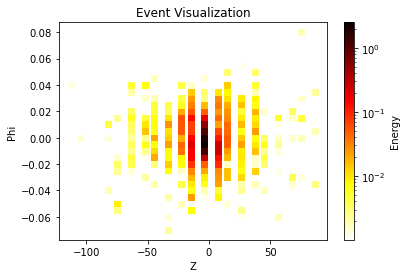

In [3]:
df_gg,True_E,total_E=getEnergyMatrix(file='DigiEcal_diphoton_1-10GeV_megered.root')

In [4]:
len(df_gg)

49912

In [5]:
df_gg=df_gg[df_gg.total_e>0]

In [6]:
len(df_gg)

49910

In [10]:
True_E=True_E[total_E>0]

In [11]:
df_gg["E1"] = True_E[:,0].to_numpy()
df_gg["E2"] = True_E[:,1].to_numpy()

/tmp/ipykernel_1791/1838618144.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gg["E1"] = True_E[:,0].to_numpy()
/tmp/ipykernel_1791/1838618144.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gg["E2"] = True_E[:,1].to_numpy()


In [ ]:
'''
for i in range(len(True_E)):
    if len(True_E[i])==2:
        print(df_gg.loc[i, "energy_matrix"])
        print(df_gg.loc[i, "energy_matrix"].sum())
        print(len(True_E[i]))
    if i>3:
        break;
'''

In [ ]:
#df_gg.loc[i, "energy_matrix"].sum()

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [20]:
# Assuming df_A and df_B are your dataframes for class A and class B
# Convert the energy matrices into numpy arrays
data = np.stack(df_gg['energy_matrix'].values)
E1=df_gg['E1'].values
E2=df_gg['E2'].values

In [21]:
# Assuming your data is in the following format
targets = np.stack((E1, E2), axis=-1)

# Reshape data for CNN if necessary
if len(data.shape) == 3:
    data = np.expand_dims(data, axis=-1)

In [69]:
# Split the data into training and testing sets
data_train, data_test, labels_train, labels_test = train_test_split(data, targets, test_size=0.2, random_state=42)

In [70]:
# Define the CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=data.shape[1:]))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2))
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history=model.fit(data_train, labels_train, epochs=30, validation_data=(data_test, labels_test),batch_size=32,callbacks=[early_stop])

Epoch 1/30
1248/1248 [==============================] - 13s 9ms/step - loss: 2.3755 - root_mean_squared_error: 1.5413 - val_loss: 1.7273 - val_root_mean_squared_error: 1.3143
Epoch 2/30
1248/1248 [==============================] - 10s 8ms/step - loss: 1.6136 - root_mean_squared_error: 1.2703 - val_loss: 1.5490 - val_root_mean_squared_error: 1.2446
Epoch 3/30
1248/1248 [==============================] - 10s 8ms/step - loss: 1.4981 - root_mean_squared_error: 1.2240 - val_loss: 1.4803 - val_root_mean_squared_error: 1.2167
Epoch 4/30
1248/1248 [==============================] - 10s 8ms/step - loss: 1.4309 - root_mean_squared_error: 1.1962 - val_loss: 1.4062 - val_root_mean_squared_error: 1.1858
Epoch 5/30
1248/1248 [==============================] - 10s 8ms/step - loss: 1.3701 - root_mean_squared_error: 1.1705 - val_loss: 1.3270 - val_root_mean_squared_error: 1.1520
Epoch 6/30
1248/1248 [==============================] - 10s 8ms/step - loss: 1.3016 - root_mean_squared_error: 1.1409 - val_l

In [71]:
test_pred=model.predict(data_test)

312/312 [==============================] - 1s 3ms/step


In [72]:
labels_test

array([[5.994662 , 4.510951 ],
       [4.4963493, 3.4333832],
       [7.582444 , 9.090625 ],
       ...,
       [5.2604   , 8.998883 ],
       [5.648748 , 2.4816325],
       [2.139986 , 1.2510258]], dtype=float32)

In [73]:
error=(test_pred-labels_test)/labels_test

In [74]:
#error=error.flatten()

In [75]:
# Compute the histogram
hist, bin_edges = np.histogram(error, bins='auto')

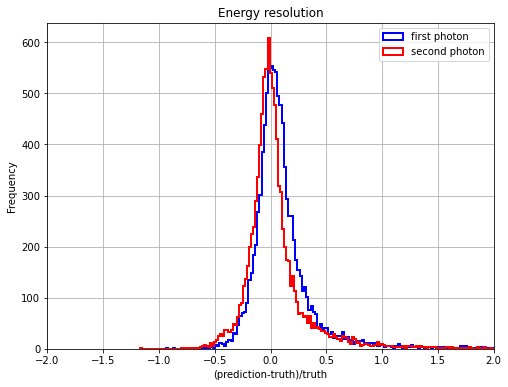

In [79]:
# Create the histogram plot
plt.figure(figsize=(8, 6))
plt.hist(error[:,0], bins='auto', color='blue', histtype='step',lw=2,label='first photon')
plt.hist(error[:,1], bins='auto', color='red', histtype='step',lw=2,label='second photon')
plt.xlabel("(prediction-truth)/truth")
plt.ylabel("Frequency")
plt.title("Energy resolution")
plt.grid(True)
plt.xlim(-2,2)
plt.legend()
plt.show()


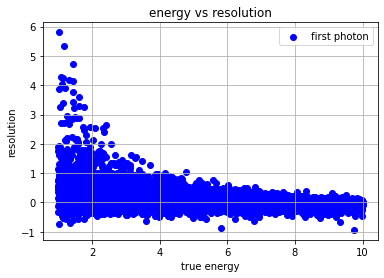

In [80]:
# Create the scatter plot
plt.scatter(labels_test[:,0], error[:,0], c="blue", label='first photon')

# Customize the plot (add labels, title, etc.)
plt.xlabel("true energy")
plt.ylabel("resolution")
plt.title("energy vs resolution")
plt.grid(True)
plt.legend()
# Show the plot
plt.show()



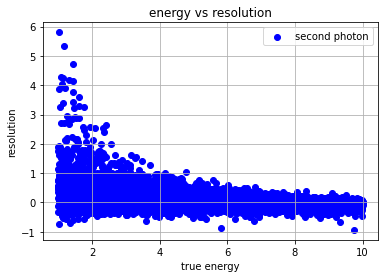

In [81]:
# Create the scatter plot
plt.scatter(labels_test[:,0], error[:,0], c="blue", label='second photon')

# Customize the plot (add labels, title, etc.)
plt.xlabel("true energy")
plt.ylabel("resolution")
plt.title("energy vs resolution")
plt.grid(True)
plt.legend()
# Show the plot
plt.show()

